In [8]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("PatternProject/Data/RealWaste") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

[]


In [7]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("PatternProject\Data\RealWaste"):

  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [16]:
from pathlib import Path
import os, numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# ==== USER CONFIG ====
REALWASTE_ROOT = r"Data/RealWaste"  # <-- change this
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 1337
TEST_SIZE = 0.20    # 20% test, 80% train
# =====================


In [17]:
root = Path(REALWASTE_ROOT)
assert root.exists(), f"Folder not found: {root}"

# collect image files
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
files = []
labels_str = []

for class_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
    cls = class_dir.name
    for fp in class_dir.rglob("*"):
        if fp.suffix.lower() in IMG_EXTS:
            files.append(str(fp))
            labels_str.append(cls)

files = np.array(files)
labels_str = np.array(labels_str)
print(f"Total images: {len(files)} across {len(set(labels_str))} classes")
print("Classes:", sorted(set(labels_str)))


Total images: 4752 across 9 classes
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [18]:
# map class name -> index
class_names = sorted(list(set(labels_str)))
class_to_idx = {c:i for i,c in enumerate(class_names)}
y = np.array([class_to_idx[c] for c in labels_str], dtype=np.int32)

# train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    files, y, test_size=TEST_SIZE, random_state=SEED, stratify=y
)

print(f"Train: {len(X_train)} | Test: {len(X_test)}")


Train: 3801 | Test: 951


In [19]:
import collections

def counts_per_split(y_split):
    counter = collections.Counter(y_split.tolist())
    return {class_names[k]: counter.get(k, 0) for k in range(len(class_names))}

print("\nPer-class counts (train):")
print(counts_per_split(y_train))
print("\nPer-class counts (test):")
print(counts_per_split(y_test))



Per-class counts (train):
{'Cardboard': 369, 'Food Organics': 329, 'Glass': 336, 'Metal': 632, 'Miscellaneous Trash': 396, 'Paper': 400, 'Plastic': 736, 'Textile Trash': 254, 'Vegetation': 349}

Per-class counts (test):
{'Cardboard': 92, 'Food Organics': 82, 'Glass': 84, 'Metal': 158, 'Miscellaneous Trash': 99, 'Paper': 100, 'Plastic': 185, 'Textile Trash': 64, 'Vegetation': 87}


In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(files, labels, class_names, target_class):
    """
    View a random image from a given class in your dataset.

    Args:
        files: np.array of file paths (X_train, X_test, etc.)
        labels: np.array of integer labels matching files
        class_names: list of class name strings (index -> name)
        target_class: str, one of the class names you want to view
    """
    # find index of this class
    class_idx = class_names.index(target_class)

    # get all file paths for this class
    class_files = files[labels == class_idx]

    # sample one
    rand_path = random.choice(class_files)

    # read and plot
    img = mpimg.imread(rand_path)
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    plt.show()

    print(f"Image path: {rand_path}")
    print(f"Image shape: {img.shape}")

    return img


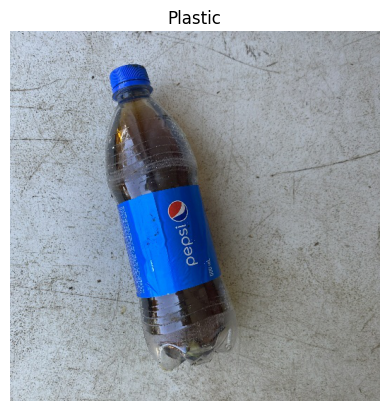

Image path: Data\RealWaste\Plastic\Plastic_307.jpg
Image shape: (524, 524, 3)


In [21]:
# say you want from the training set
img = view_random_image(X_train, y_train, class_names, target_class="Plastic")


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [26]:
import tensorflow as tf

IMG_SIZE = (224, 224)   # you can keep 128 if preferred
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def decode_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0   # rescale like ImageDataGenerator
    return img, label

# ---- train dataset ----
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1000, seed=1337)
train_ds = train_ds.map(decode_resize, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# ---- test dataset ----
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(decode_resize, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

# Simple scratch CNN (multi-class with 9 outputs)
model_9 = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),

    Conv2D(64, 3, activation='relu'),
    BatchNormalization(),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(9, activation='softmax')  # 9 classes for RealWaste
])

# Compile with integer-label loss
model_9.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


In [29]:
import numpy as np

# Count how many samples per class in y_train
train_counts = np.bincount(y_train, minlength=len(set(y_train)))
total = train_counts.sum()
num_classes = len(train_counts)

# Compute class_weight dictionary
class_weight = {
    i: total / (num_classes * train_counts[i]) 
    for i in range(num_classes) if train_counts[i] > 0
}

print("Class weights:", class_weight)


Class weights: {0: 1.1445347786811202, 1: 1.2836879432624113, 2: 1.2569444444444444, 3: 0.6682489451476793, 4: 1.0664983164983164, 5: 1.0558333333333334, 6: 0.573822463768116, 7: 1.662729658792651, 8: 1.210124164278892}


In [ ]:
history_9 = model_9.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    class_weight=class_weight   # <--- now defined
)


Epoch 1/20
119/119 [==============================] - 21s 130ms/step - loss: 3.8196 - accuracy: 0.2165 - val_loss: 2.2288 - val_accuracy: 0.0883
Epoch 2/20
119/119 [==============================] - 13s 111ms/step - loss: 2.0999 - accuracy: 0.2060 - val_loss: 2.2466 - val_accuracy: 0.0883
Epoch 3/20
119/119 [==============================] - 13s 111ms/step - loss: 2.1458 - accuracy: 0.2031 - val_loss: 2.1970 - val_accuracy: 0.1661
Epoch 4/20
119/119 [==============================] - 13s 111ms/step - loss: 2.1172 - accuracy: 0.2236 - val_loss: 2.1944 - val_accuracy: 0.1767
Epoch 5/20
 32/119 [=======>......................] - ETA: 9s - loss: 2.0655 - accuracy: 0.2432